# Lecture 5: Nuclear norm, matrix completion, conditional gradient

[EE227C course page](https://ee227c.github.io/)  
[Download ipynb file](https://ee227c.github.io/code/lecture5.ipynb)

Overview:

* [Nuclear norm](#nuclear-norm)
* [Low-rank matrix completion](#matrix-completion)
* [Projected gradient descent for matrix completion](#projected-gd)
* [Conditional gradient for matrix completion](#conditional-gd)
* [Running-time comparison](#running-time)


In the blackboard part of this lecture we explored the convergence properties of the *conditional gradient* method for smooth convex optimization. We saw how the algorithm avoids a projection step in favor of a sometimes cheaper linear optimization over the constraint set. Here we illustrate this idea in one important application known as *matrix completion*.

In [3]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(1337)
from timeit import timeit

from optimizers import gradient_descent
from plotters import convergence_plot, kwargs, setup_layout

setup_layout()

<a name="nuclear-norm"></a>

## Nuclear Norm

The *nuclear norm* (sometimes called *Schatten $1$-norm* or *trace norm*) of a matrix $A$, denoted $\|A\|_*$, is defined as the sum of its singular values

<p>
$$ \|A\|_* = \sum_i \sigma_i(A)\,.$$
</p>

The norm can be computed from the singular value decomposition of $A$.

In [4]:
def nuclear_norm(A):
    """Nuclear norm of input matrix"""
    return np.sum(np.linalg.svd(A)[1])

### Projection onto the nuclear norm ball

We denote the unit ball of the nuclear norm by 
<p>
$$B_*^{m\times n}=\{A\in\mathbb{R}^{m\times n} \mid \|A\|_*\le 1\}.$$
</p>

How can we project a matrix $A$ onto $B_*$? Formally, we want to solve

<p>
$$\min_{X\in B_*}\|A-X\|_F^2$$
</p>

Due to the rotational invariance of the Frobenius norm, the solution is obtained by projecting the singular values onto the unit simplex. This operation corresponds to shifting all singular values by the same parameter $\theta$ and clipping values at $0$ so that the sum of the shifted and clipped values is equal to $1.$

In [5]:
def simplex_projection(s):
    """Projection onto the unit simplex."""
    if np.sum(s) <=1 and np.alltrue(s >= 0):
        return s
    # Code taken from https://gist.github.com/daien/1272551
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, len(u)+1) > (cssv - 1))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - 1) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    return np.maximum(s-theta, 0)

def nuclear_projection(A):
    """Projection onto nuclear norm ball."""
    U, s, V = np.linalg.svd(A, full_matrices=False)
    s = simplex_projection(s)
    return U.dot(np.diag(s).dot(V))

The nuclear norm projection is *not* a cheap operation. It requires a full SVD of the input matrix that in general requires cubic time. Below we illustrate that even on small input sizes, a single projection step is time-consuming. 

In [6]:
ts = []
ns = [1000, 2000, 3000, 4000]
for n in ns:
    f = lambda: nuclear_projection(np.random.normal(0,1,(n, n)))
    ts.append(timeit(f, number=1))

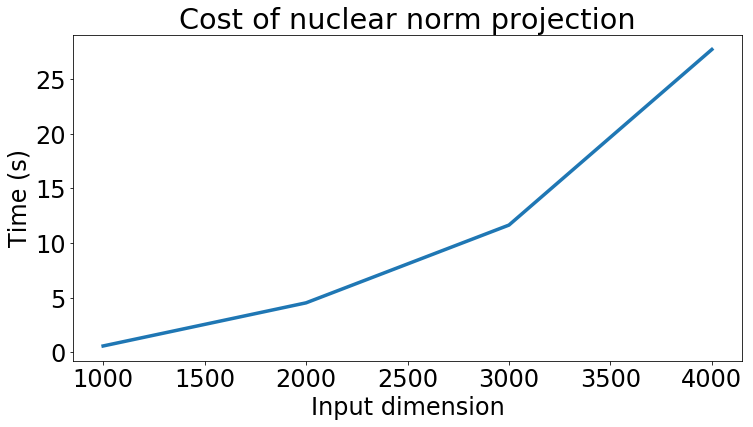

In [7]:
plt.figure(figsize=(12,6))
plt.xlabel('Input dimension')
plt.ylabel('Time (s)')
plt.title('Cost of nuclear norm projection')
plt.plot(ns, ts, **kwargs)

<a name="matrix-completion"></a>

## Low-Rank Matrix Completion

In [8]:
n, k = 1000, 10
# random rank-10 matrix normalized to have nuclear norm 1
U = np.random.normal(0, 1, (n, k))
U = np.linalg.qr(U)[0]
S = np.diag(np.random.uniform(0, 1, k))
S /= np.sum(S)
A = U.dot(S.dot(U.T))
# pick which entries we observe uniformly at random
O = np.random.randint(0,2, (n, n))
# multiply A by O coordinate-wise
Y = np.multiply(A, O)

def mc_objective(Y, O, X):
    """Matrix completion objective."""
    return 0.5 * np.linalg.norm(Y-np.multiply(X, O), 'fro')**2

def mc_gradient(Y, O, X):
    """Gradient of matrix completion objective."""
    return np.multiply(X, O) - Y

<a name="projected-gd"></a>

## Projected gradient descent for matrix completion

In [9]:
# start from random matrix of nuclear norm 1
X0 = np.random.normal(0,1, (n,n))
X0 = nuclear_projection(X0.dot(X0.T))
objective = lambda X: mc_objective(Y, O, X)
gradient = lambda X: mc_gradient(Y, O, X)
Xs = gradient_descent(X0, [0.2]*40, gradient, nuclear_projection)

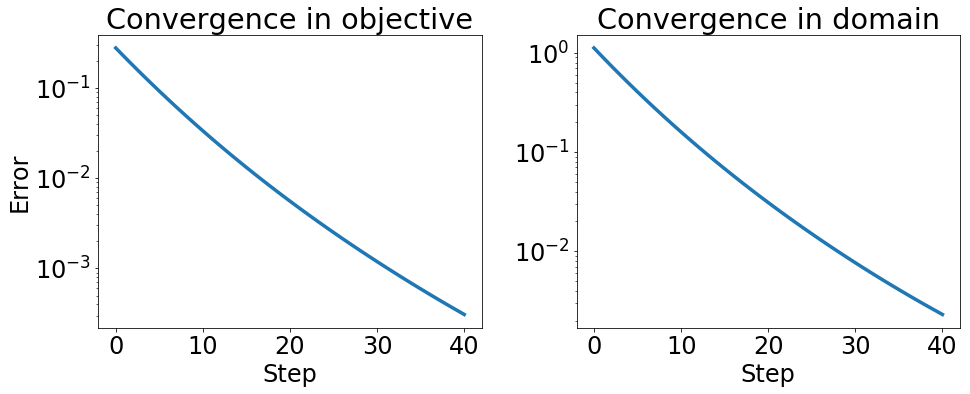

In [10]:
convergence_plot([objective(X) for X in Xs],
                [np.linalg.norm(A-X, 'fro')**2 for X in Xs])

### Singular values of recovered solution

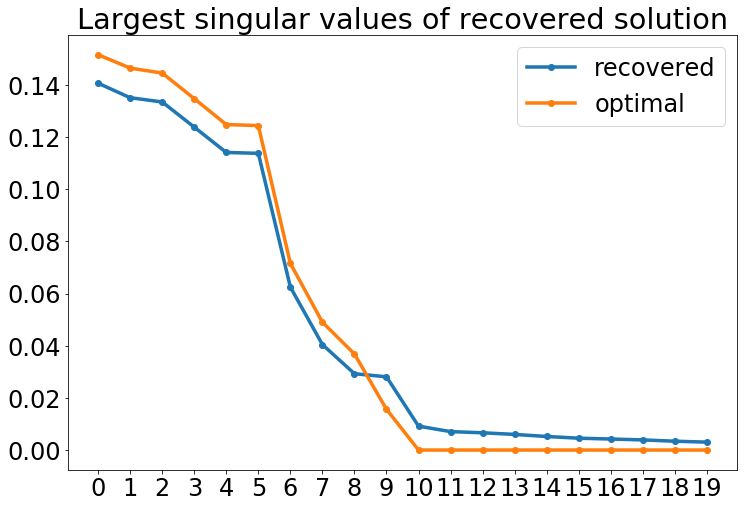

In [11]:
_, S_opt, V = np.linalg.svd(A, full_matrices=False)
_, S, _ = np.linalg.svd(Xs[-1], full_matrices=False)
plt.figure(figsize=(12,8))
plt.title('Largest singular values of recovered solution')
plt.plot(range(20), np.sort(S)[::-1][:20], 'o-', label='recovered', **kwargs)
plt.plot(range(20), np.sort(S_opt)[::-1][:20], 'o-', label='optimal', **kwargs)
plt.xticks(range(20))
plt.legend()

<a name="conditional-gd"></a>

## Conditional gradient for matrix completion

We now compare projected gradient descent for matrix completion with *conditional gradient*.

In [12]:
def conditional_gradient(initial, steps, oracle):
    """Conditional gradient.
    
        Conditional grdient (Frank-Wolfe) for first-order optimization.
    
    Parameters:
    -----------
        initial: array,
            initial starting point
        steps: list of numbers,
            step size schedule
        oracle: function,
            mapping points to points, implements linear optimization 
            oracle for the objective.
    
    Returns:
    --------
        List of points computed by the algorithm.
    """
    xs = [initial]
    for step in steps:
        xs.append(xs[-1] + step*(oracle(xs[-1])-xs[-1]))
    return xs

To implement the linear optimization oracle required by conditional gradient, we will need a way of computing a good rank-$1$ approximation of a given matrix. We will do this using an (unoptimized) ad-hoc implementation of the power method.

In [16]:
def power_method(A, num_steps=10):
    """Power method.
        
        Computes approximate top left and right singular vector.
        
    Parameters:
    -----------
        A : array {m, n},
            input matrix
        num_steps : integer, optional
            number of steps
            
    Returns:
    --------
        x, y : (m,), (n,)
            two arrays representing approximate top left and right
            singular vectors.
    """
    m, n = A.shape
    x = np.random.normal(0,1, m)
    x /= np.linalg.norm(x)
    y = A.T.dot(x)
    y /= np.linalg.norm(y)
    for _ in range(num_steps):      
        x = A.dot(y)
        x /= np.linalg.norm(x)
        y = A.T.dot(x)
        y /= np.linalg.norm(y)        
    return x, y

As shown in the lecture, the linear optimization oracle boils down to computing the gradient (a matrix in this case), and computing the best rank one approximation of the negative gradient.

In [17]:
def mc_oracle(Y, O, X):
    """Linear optimization oracle for matrix completion."""
    G = mc_gradient(Y, O, X)
    x, y = power_method(-G)
    return x.reshape((len(x), 1)).dot(y.reshape((1,len(y))))

In [18]:
n, k = 1000, 10
# random rank-10 matrix normalized to have nuclear norm 1
U = np.random.normal(0, 1, (n, k))
U = np.linalg.qr(U)[0]
S = np.diag(np.random.uniform(0, 1, k))
S /= np.sum(S)
A = U.dot(S.dot(U.T))
# pick which entries we observe uniformly at random
O = np.random.randint(0,2, (n, n))
# multiply A by O coordinate-wise
Y = np.multiply(A, O)

In [20]:
X0 = np.random.normal(0,1, (n,n))
X0 = nuclear_projection(X0.dot(X0.T))
oracle = lambda X: mc_oracle(Y, O, X)
steps = [2./(k+2.) for k in range(1, 40)]
Xs = conditional_gradient(X0, steps, oracle)

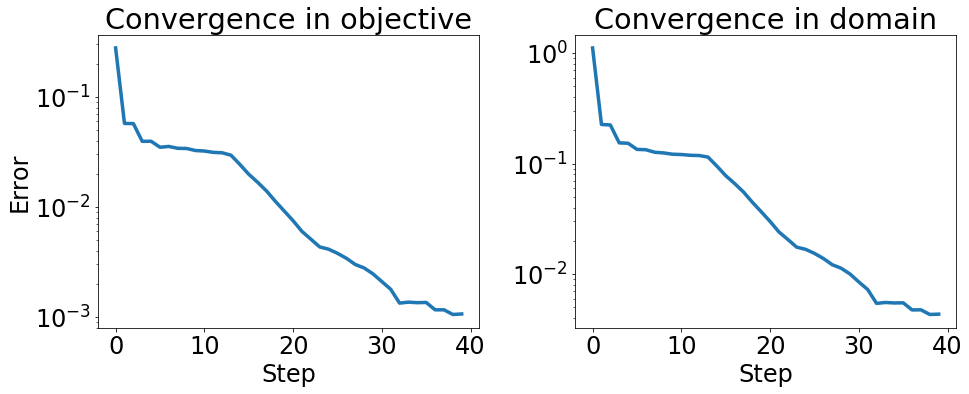

In [21]:
convergence_plot([objective(X) for X in Xs],
                [np.linalg.norm(A-X, 'fro')**2 for X in Xs])

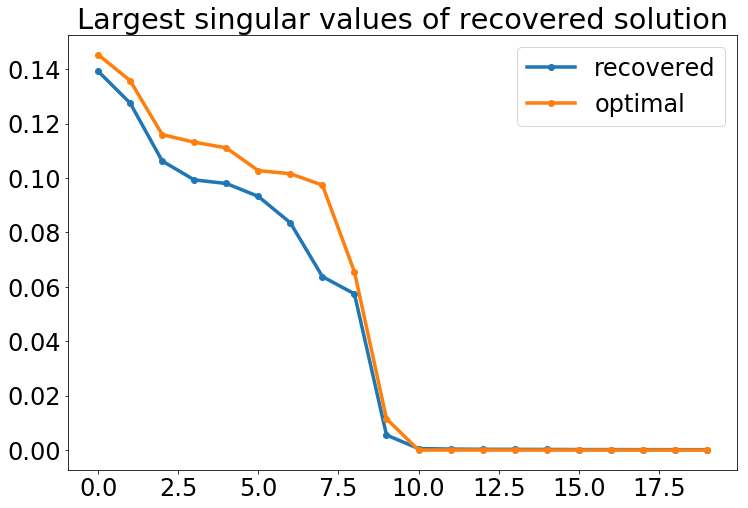

In [22]:
_, S_opt, V = np.linalg.svd(A, full_matrices=False)
_, S, _ = np.linalg.svd(Xs[-1], full_matrices=False)
plt.figure(figsize=(12,8))
plt.title('Largest singular values of recovered solution')
plt.plot(range(20), np.sort(S)[::-1][:20], 'o-', label='recovered', **kwargs)
plt.plot(range(20), np.sort(S_opt)[::-1][:20], 'o-', label='optimal', **kwargs)
plt.legend()

The solution we see here is similar in quality to the one computed by projected gradient descent. As we will see next though the algorithm is a lot faster.

<a name="running-time"></a>

## Running-time comparison

Naively, the projection step onto the nuclear norm ball costs time $O(n^3)$ for and $n\times n$ matrix. The cost of the linear optimization oracle for conditional gradient can be approximated a lot cheaper. In our naive implementation we make a few iterations of the power method, where each iteration costs $O(n^2)$ times. On large sparse matrices, we only pay for the number of nonzero entries in each iteration. Computing the top singular vector is also a fairly robust operation, whereas computing all singular vectors of a matrix requires computing singular values close to zero.

It's worth noting that the number of iterations we chose for the power method is not necessarily large enough to tease apart the first from the second singular vector in domain. Nonetheless it will succeed at finding a vector with large Rayleigh coefficient.

In [23]:
ts1 = []
ts2 = []
ns = [1000, 2000, 3000, 4000]
for n in ns:
    f = lambda: nuclear_projection(np.random.normal(0,1,(n, n)))
    ts1.append(timeit(f, number=1))
    Y = np.random.normal(0,1, (n, n))
    O = np.random.randint(0, 2, (n, n))
    X = np.random.normal(0,1, (n, n))
    f = lambda: mc_oracle(Y, O, X)
    ts2.append(timeit(f, number=1))

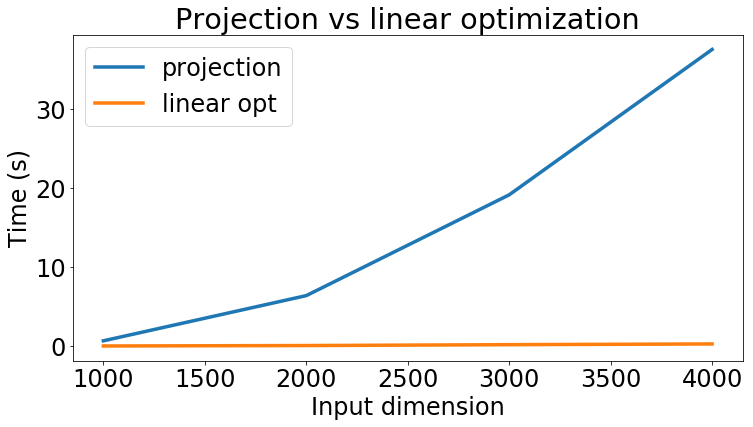

In [18]:
plt.figure(figsize=(12,6))
plt.xlabel('Input dimension')
plt.ylabel('Time (s)')
plt.title('Projection vs linear optimization')
plt.plot(ns, ts1, label='projection', **kwargs)
plt.plot(ns, ts2, label='linear opt', **kwargs)
plt.legend()

The different order of magnitude is clearly visible from this plot.

## That's it. Thanks.